In [1]:
import os 
import torch 
import matplotlib 
import numpy as np  
import pandas as pd 
import seaborn as sns 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score 
from scipy.interpolate import UnivariateSpline
from torchvision import datasets, models, transforms, utils
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir        = 'patches/img_0_padded'
num_workers     = 4
crop_size       = 10 
data_transforms = transforms.Compose([transforms.CenterCrop(10),
                                      transforms.Grayscale(),
                                      transforms.ToTensor()])
device          = torch.device("cpu")#cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_dataset   = datasets.ImageFolder(os.path.join(data_dir),data_transforms)
dataloader      = torch.utils.data.DataLoader(image_dataset,num_workers=num_workers,batch_size=len(image_dataset))
images,labels   = next(iter(dataloader))

images = images.to(device, torch.uint8)

In [4]:
images = images.reshape(len(images),-1)
images = images.cpu().numpy() 
images = StandardScaler().fit_transform(images)

In [5]:
clusters=range(2,20) 

summed_square_distance=[]
calinski_score=[]

for i in clusters: 
    kmeans=KMeans(n_clusters=i,init='random',random_state=1)
    kmeans=kmeans.fit(images)
    summed_square_distance.append(kmeans.inertia_)
    calinski_score.append(calinski_harabasz_score(images,kmeans.labels_))

In [6]:
#2nd derivative of elbow curve to find optimal number of clusters 
spline    = UnivariateSpline(clusters,summed_square_distance)
spline_d2 = spline.derivative(n=3) 

In [7]:
d2_list = list(spline_d2(clusters))
idx_max = max(range(len(d2_list)),key=d2_list.__getitem__)
n_clusters=idx_max + min(clusters)

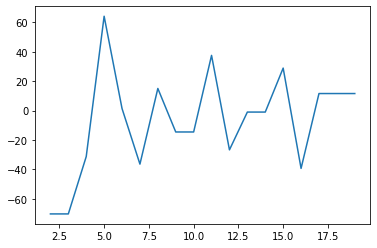

In [8]:
plt.figure() 
plt.plot(clusters,spline_d2(clusters))
plt.show() 

In [9]:
print(n_clusters)
model = KMeans(n_clusters=n_clusters, random_state=0)
model.fit(images)
Y = model.labels_ 

5


<Figure size 432x288 with 0 Axes>

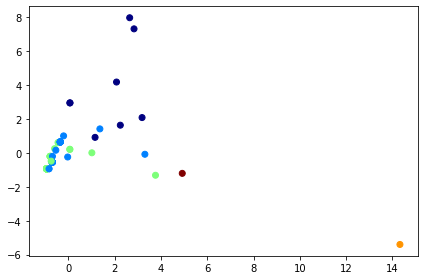

In [10]:
#PCA to 2D 
pca           = PCA(n_components=2)
pca_transform = pca.fit_transform(images)

plt.figure()
fig=plt.figure()
ax=fig.add_subplot(111)
i=0
pca_holder = pd.DataFrame(columns=['pca0','pca1','label'])
pca_holder['pca0']   = pca_transform[:,0]
pca_holder['pca1']   = pca_transform[:,1]
pca_holder['labels'] = Y 
unique_labels = set(pca_holder['labels']) 
plt.scatter(pca_transform[:,0],pca_transform[:,1], c=Y,cmap=plt.cm.jet)
plt.tight_layout() 
plt.savefig('pca_plot.png')

In [11]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
            
        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
    
    return inferred_labels

/var/folders/6q/tjthdmrn66qgrg4m_bh_sj580000gq/T/ipykernel_3359/1686830006.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


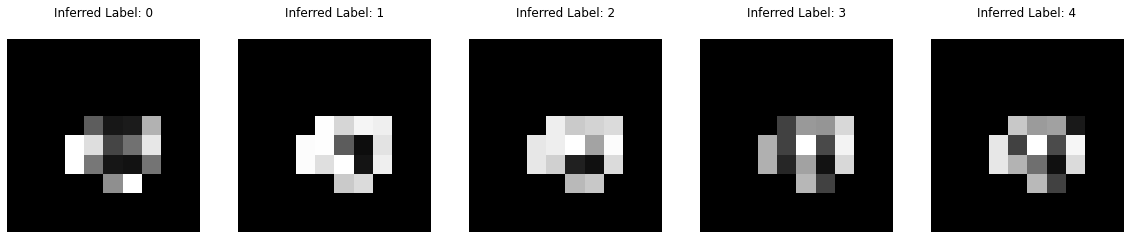

In [12]:
centroids = model.cluster_centers_
images = centroids.reshape(n_clusters, crop_size, crop_size)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(model, Y)



# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(1, 5, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()